In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df_sales = pd.read_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\pizza_sales.csv", sep=";")

# Converter para datetime, tratando múltiplos formatos
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'], format='%d/%m/%Y', errors='coerce').fillna(
             pd.to_datetime(df_sales['order_date'], format='%d-%m-%Y', errors='coerce'))
df_sales['unit_price'] = df_sales['unit_price'].str.replace(',', '.').astype(float)
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.time
df_sales['order_hour'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.hour
df_sales['day_of_week'] = df_sales['order_date'].dt.day_name()
df_sales['pizza_type_id'] = df_sales['pizza_name_id'].str.rsplit('_', n=1).str[0]
df_sales['total_price'] = df_sales['quantity']*df_sales['unit_price']
df_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,M,11,Thursday,hawaiian,13.25
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,classic_dlx,16.00
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,L,11,Thursday,five_cheese,18.50
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,L,11,Thursday,ital_supr,20.75
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,mexicana,16.00


In [3]:
df_types = pd.read_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\pizza_types.csv", sep=";")
df_types.head()

,pizza_type_id,pizza_name,pizza_category,pizza_ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,big_meat,The Big Meat Pizza,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau..."
2,brie_carre,The Brie Carre Pizza,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni..."
3,calabrese,The Calabrese Pizza,Supreme,"Nduja Salami, Pancetta, Tomatoes, Red Onions, ..."
4,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."


In [4]:
# Unir as tabelas para ter os nomes das pizzas e seus ingredientes no dataframe principal
df_pizza = df_sales.merge(df_types, on='pizza_type_id', how='left')
df_pizza

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price,pizza_name,pizza_category,pizza_ingredients
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,M,11,Thursday,hawaiian,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese"
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,classic_dlx,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,L,11,Thursday,five_cheese,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,L,11,Thursday,ital_supr,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni..."
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,mexicana,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,M,21,Thursday,ckn_alfredo,16.75,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,L,21,Thursday,four_cheese,17.95,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo..."
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,S,21,Thursday,napolitana,12.00,The Napolitana Pizza,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,..."
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,L,22,Thursday,mexicana,20.25,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."


In [5]:
df_pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   pizza_size         48620 non-null  object        
 8   order_hour         48620 non-null  int32         
 9   day_of_week        48620 non-null  object        
 10  pizza_type_id      48620 non-null  object        
 11  total_price        48620 non-null  float64       
 12  pizza_name         48620 non-null  object        
 13  pizza_category     48620 non-null  object        
 14  pizza_

In [6]:
df_pizza.describe()

,pizza_id,order_id,quantity,order_date,unit_price,order_hour,total_price
count,48620.000000,48620.000000,48620.000000,48620,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,2015-06-29 11:03:43.611682560,16.494132,15.911806,16.821474
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.000000,9.750000
25%,12155.750000,5337.000000,1.000000,2015-03-31 00:00:00,12.750000,13.000000,12.750000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.000000,16.500000
75%,36465.250000,16100.000000,1.000000,2015-09-28 00:00:00,20.250000,18.000000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,23.000000,83.000000
std,14035.529381,6180.119770,0.143077,NaN,3.621789,3.149836,4.437398


In [7]:
df_pizza.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
pizza_size           0
order_hour           0
day_of_week          0
pizza_type_id        0
total_price          0
pizza_name           0
pizza_category       0
pizza_ingredients    0
dtype: int64

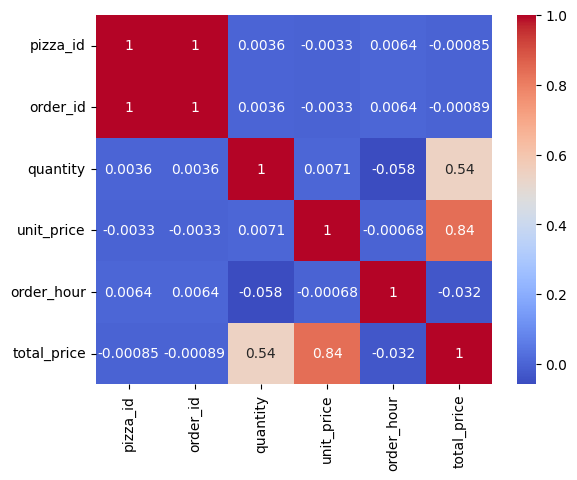

In [8]:
numeric_columns = df_pizza.select_dtypes(include=['number'])
sns.heatmap(numeric_columns.corr(), cmap='coolwarm', annot=True)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15968\521543941.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


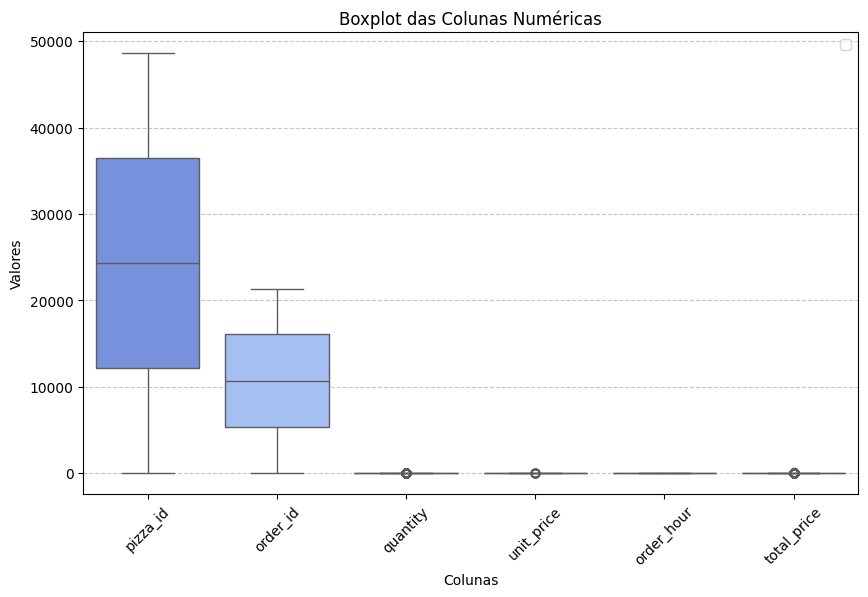

In [9]:
numeric_data = df_pizza.select_dtypes(include='number')

# Criar o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=numeric_data, palette="coolwarm")

# Ajustar rótulos e título
plt.xticks(rotation=45)
plt.title('Boxplot das Colunas Numéricas')
plt.xlabel('Colunas')
plt.ylabel('Valores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [10]:
# Calcular IQR (Interquartile Range)
Q1 = df_pizza['total_price'].quantile(0.25)
Q3 = df_pizza['total_price'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_pizza[(df_pizza['total_price'] < lower_bound) | (df_pizza['total_price'] > upper_bound)]

# Exibir resumo dos outliers
print(f"Outliers detectados: {len(outliers)}")
print(f"Faixa normal: {lower_bound:.2f} a {upper_bound:.2f}")
print(f"Estatísticas dos outliers:\n{outliers.describe()}")

# Exibir todos os outliers
outliers

Outliers detectados: 613
Faixa normal: 1.12 a 32.12
Estatísticas dos outliers:
           pizza_id      order_id    quantity                     order_date  \
count    613.000000    613.000000  613.000000                            613   
mean   24507.375204  10786.477977    1.998369  2015-07-01 01:29:15.954322944   
min      184.000000     78.000000    1.000000            2015-01-02 00:00:00   
25%    13275.000000   5820.000000    2.000000            2015-04-08 00:00:00   
50%    24015.000000  10555.000000    2.000000            2015-06-26 00:00:00   
75%    36993.000000  16330.000000    2.000000            2015-10-02 00:00:00   
max    48602.000000  21343.000000    4.000000            2015-12-31 00:00:00   
std    13850.366160   6098.924533    0.315706                            NaN   

       unit_price  order_hour  total_price  
count  613.000000  613.000000   613.000000  
mean    19.784584   14.675367    38.624878  
min     12.000000   10.000000    32.500000  
25%     16.750000   

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price,pizza_name,pizza_category,pizza_ingredients
183,184,78,spicy_ital_l,3,2015-01-02,12:28:14,20.75,L,12,Friday,spicy_ital,62.25,The Spicy Italian Pizza,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ..."
211,212,91,bbq_ckn_l,2,2015-01-02,15:14:43,20.75,L,15,Friday,bbq_ckn,41.50,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
341,342,144,bbq_ckn_m,3,2015-01-03,13:44:28,16.75,M,13,Saturday,bbq_ckn,50.25,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
456,457,193,ckn_alfredo_l,2,2015-01-03,20:55:47,20.75,L,20,Saturday,ckn_alfredo,41.50,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
611,612,271,cali_ckn_m,2,2015-01-05,14:22:19,16.75,M,14,Monday,cali_ckn,33.50,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48396,48397,21251,four_cheese_l,2,2015-12-30,12:45:20,17.95,L,12,Wednesday,four_cheese,35.90,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo..."
48417,48418,21260,prsc_argla_m,2,2015-12-30,15:45:32,16.50,M,15,Wednesday,prsc_argla,33.00,The Prosciutto and Arugula Pizza,Supreme,"Prosciutto di San Daniele, Arugula, Mozzarella..."
48466,48467,21288,classic_dlx_m,3,2015-12-31,13:04:18,16.00,M,13,Thursday,classic_dlx,48.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
48575,48576,21331,bbq_ckn_l,2,2015-12-31,19:05:04,20.75,L,19,Thursday,bbq_ckn,41.50,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."


### Análise de Vendas e Receita

In [11]:
# Pizzas mais vendidas
top_pizzas = df_pizza.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False)
print('Pizzas mais vendidas:')
print(top_pizzas.head(10))

Pizzas mais vendidas:
pizza_name
The Classic Deluxe Pizza        2453
The Barbecue Chicken Pizza      2432
The Hawaiian Pizza              2422
The Pepperoni Pizza             2418
The Thai Chicken Pizza          2371
The California Chicken Pizza    2370
The Sicilian Pizza              1938
The Spicy Italian Pizza         1924
The Southwest Chicken Pizza     1917
The Big Meat Pizza              1914
Name: quantity, dtype: int64


In [12]:
revenue_per_pizza = df_pizza.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False)
print('Total faturado por pizza:')
print(revenue_per_pizza.head(10))

Total faturado por pizza:
pizza_name
The Thai Chicken Pizza          43434.25
The Barbecue Chicken Pizza      42768.00
The California Chicken Pizza    41409.50
The Classic Deluxe Pizza        38180.50
The Spicy Italian Pizza         34831.25
The Southwest Chicken Pizza     34705.75
The Italian Supreme Pizza       33476.75
The Hawaiian Pizza              32273.25
The Four Cheese Pizza           32265.70
The Sicilian Pizza              30940.50
Name: total_price, dtype: float64


In [13]:
top_pizzas = df_pizza.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False)
print('Pizzas mais vendidas:')
print(top_pizzas.head(10))

Pizzas mais vendidas:
pizza_name
The Classic Deluxe Pizza        2453
The Barbecue Chicken Pizza      2432
The Hawaiian Pizza              2422
The Pepperoni Pizza             2418
The Thai Chicken Pizza          2371
The California Chicken Pizza    2370
The Sicilian Pizza              1938
The Spicy Italian Pizza         1924
The Southwest Chicken Pizza     1917
The Big Meat Pizza              1914
Name: quantity, dtype: int64


In [14]:
revenue_per_unit = revenue_per_pizza / top_pizzas
revenue_per_unit = revenue_per_unit.sort_values(ascending=False)
print('Faturamento por unidade vendida:')
print(revenue_per_unit.head(10))

Faturamento por unidade vendida:
pizza_name
The Brie Carre Pizza           23.650000
The Greek Pizza                20.038099
The Five Cheese Pizza          18.500000
The Thai Chicken Pizza         18.318958
The Southwest Chicken Pizza    18.104199
The Spicy Italian Pizza        18.103560
The Mexicana Pizza             18.046327
The Italian Supreme Pizza      17.768976
The Pepper Salami Pizza        17.654910
The Barbecue Chicken Pizza     17.585526
dtype: float64


In [15]:
# Pizzas mais vendidas
top_pizzas_category = df_pizza.groupby('pizza_category')['quantity'].sum().sort_values(ascending=False)
print('Categorias de pizzas mais vendidas:')
print(top_pizzas_category.head(10))

Categorias de pizzas mais vendidas:
pizza_category
Classic    14888
Supreme    11987
Veggie     11649
Chicken    11050
Name: quantity, dtype: int64


In [16]:
revenue_per_pizza_category = df_pizza.groupby('pizza_category')['total_price'].sum().sort_values(ascending=False)
print('Total faturado por categoria de pizza:')
print(revenue_per_pizza_category.head(10))

Total faturado por categoria de pizza:
pizza_category
Classic    220053.10
Supreme    208197.00
Chicken    195919.50
Veggie     193690.45
Name: total_price, dtype: float64


In [17]:
revenue_per_unit_category = revenue_per_pizza_category / top_pizzas_category
revenue_per_unit_category = revenue_per_unit_category.sort_values(ascending=False)
print('Faturamento médio por categoria:')
print(revenue_per_unit_category.head(10))

Faturamento médio por categoria:
pizza_category
Chicken    17.730271
Supreme    17.368566
Veggie     16.627217
Classic    14.780568
dtype: float64


In [18]:
# Ticket médio
ticket_medio = df_pizza.groupby('order_id')['total_price'].sum().mean()
print(f'Ticket médio por pedido: ${ticket_medio:.2f}')

Ticket médio por pedido: $38.31


## Análise por tamanho das pizzas

In [19]:
# Total de pizzas vendidas por tamanho
sales_by_size = df_pizza.groupby('pizza_size')['quantity'].sum().sort_values(ascending=False)
sales_by_size

pizza_size
L      18956
M      15635
S      14403
XL       552
XXL       28
Name: quantity, dtype: int64

In [20]:
# Receita total por tamanho
revenue_by_size = df_pizza.groupby('pizza_size')['total_price'].sum().sort_values(ascending=False)
revenue_by_size

pizza_size
L      375318.70
M      249382.25
S      178076.50
XL      14076.00
XXL      1006.60
Name: total_price, dtype: float64

In [21]:
# Preço médio por tamanho
avg_price_by_size = df_pizza.groupby('pizza_size')['unit_price'].mean()
avg_price_by_size

pizza_size
L      19.802553
M      15.951219
S      12.364328
XL     25.500000
XXL    35.950000
Name: unit_price, dtype: float64

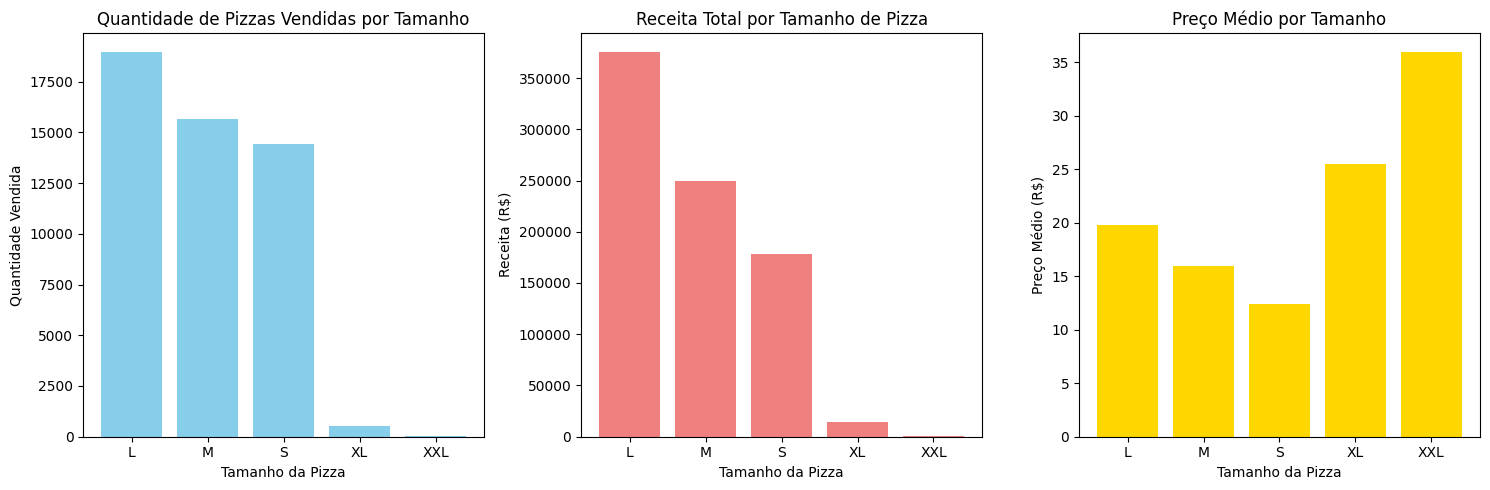

In [ ]:
# Visualizar os resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de pizzas mais vendidas por tamanho
axes[0].bar(sales_by_size.index, sales_by_size.values, color='skyblue')
axes[0].set_title("Quantidade de Pizzas Vendidas por Tamanho")
axes[0].set_xlabel("Tamanho da Pizza")
axes[0].set_ylabel("Quantidade Vendida")

# Gráfico de receita por tamanho
axes[1].bar(revenue_by_size.index, revenue_by_size.values, color='lightcoral')
axes[1].set_title("Receita Total por Tamanho de Pizza")
axes[1].set_xlabel("Tamanho da Pizza")
axes[1].set_ylabel("Receita (R$)")

# Gráfico de preço médio por tamanho
axes[2].bar(avg_price_by_size.index, avg_price_by_size.values, color='gold')
axes[2].set_title("Preço Médio por Tamanho")
axes[2].set_xlabel("Tamanho da Pizza")
axes[2].set_ylabel("Preço Médio (R$)")

plt.tight_layout()
plt.show()

### Análise Temporal

In [23]:
# Total de pizzas vendidas por dia da semana
sales_by_day = df_pizza.groupby('day_of_week')['quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
sales_by_day

day_of_week
Monday       6485
Tuesday      6895
Wednesday    6946
Thursday     7478
Friday       8242
Saturday     7493
Sunday       6035
Name: quantity, dtype: int64

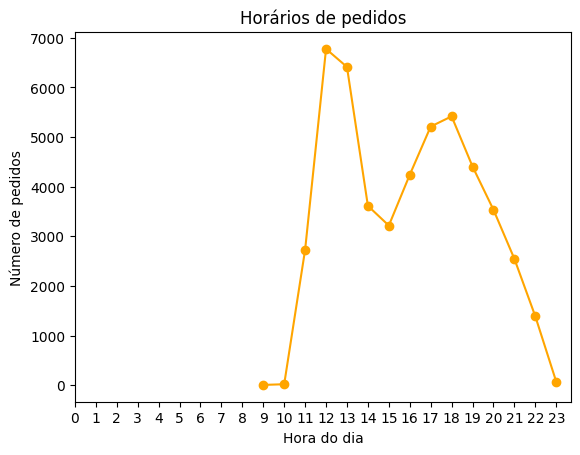

In [24]:
# Total de pizzas vendidas por horário do dia
sales_by_hour = df_pizza.groupby('order_hour')['quantity'].sum()
plt.plot(sales_by_hour.index, sales_by_hour.values, marker='o', linestyle='-', color='orange')
plt.xlabel('Hora do dia')
plt.ylabel('Número de pedidos')
plt.title('Horários de pedidos')
plt.xticks(range(0, 24))
# plt.grid()
plt.show()

In [25]:
# Faturamento acumulado ao longo do tempo
df_pizza['cumulative_revenue'] = df_pizza['total_price'].cumsum()

In [26]:
# Qtd média de pizzas por pedido
avg_pizza_per_order = df_pizza.groupby('order_date')['quantity'].mean()

C:\Users\User\AppData\Local\Temp\ipykernel_15968\963120561.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_day.index, y=sales_by_day.values, ax=axes[0, 0], palette="Blues")


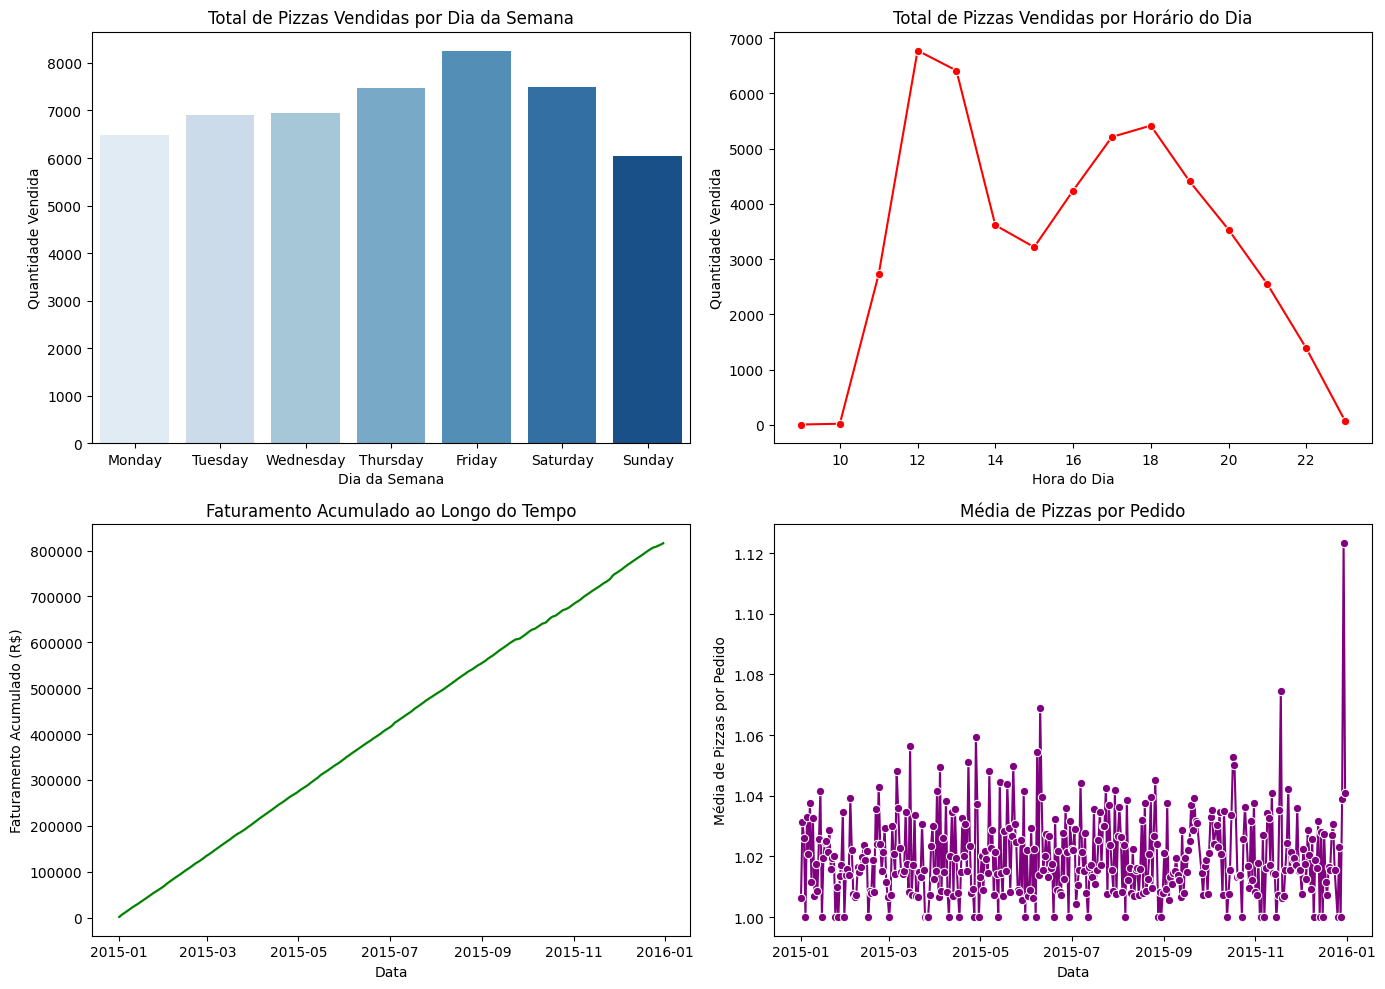

In [27]:
# Criando os gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Vendas por dia da semana
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, ax=axes[0, 0], palette="Blues")
axes[0, 0].set_title("Total de Pizzas Vendidas por Dia da Semana")
axes[0, 0].set_xlabel("Dia da Semana")
axes[0, 0].set_ylabel("Quantidade Vendida")

# Gráfico 2: Vendas por horário do dia
sns.lineplot(x=sales_by_hour.index, y=sales_by_hour.values, marker="o", ax=axes[0, 1], color='red')
axes[0, 1].set_title("Total de Pizzas Vendidas por Horário do Dia")
axes[0, 1].set_xlabel("Hora do Dia")
axes[0, 1].set_ylabel("Quantidade Vendida")

# Gráfico 3: Faturamento acumulado ao longo do tempo
sns.lineplot(x=df_pizza['order_date'], y=df_pizza['cumulative_revenue'], ax=axes[1, 0], color='green')
axes[1, 0].set_title("Faturamento Acumulado ao Longo do Tempo")
axes[1, 0].set_xlabel("Data")
axes[1, 0].set_ylabel("Faturamento Acumulado (R$)")

# Gráfico 4: Qtd média de pizzas por pedido ao longo do tempo
sns.lineplot(x=avg_pizza_per_order.index, y=avg_pizza_per_order.values, marker="o", ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Média de Pizzas por Pedido")
axes[1, 1].set_xlabel("Data")
axes[1, 1].set_ylabel("Média de Pizzas por Pedido")

plt.tight_layout()
plt.show()

Com isso, identificamos que: 
- O número de pedidos na semana é maior na sexta-feira;
- A pizzaria tem poucos pedidos no começo do dia, começando a ter um número maior de pedidos após às 11h
- O faturamento acumulado ao longo do ano é praticamente linear, o que indica que os resultados estão consistentes.

In [28]:
# Criar colunas auxiliares para análise semanal
df_pizza['year'] = df_pizza['order_date'].dt.year  # Ano do pedido
df_pizza['month'] = df_pizza['order_date'].dt.month  # Mês do pedido
df_pizza['week_of_month'] = df_pizza['order_date'].apply(lambda d: (d.day - 1) // 7 + 1)  # Semana dentro do mês

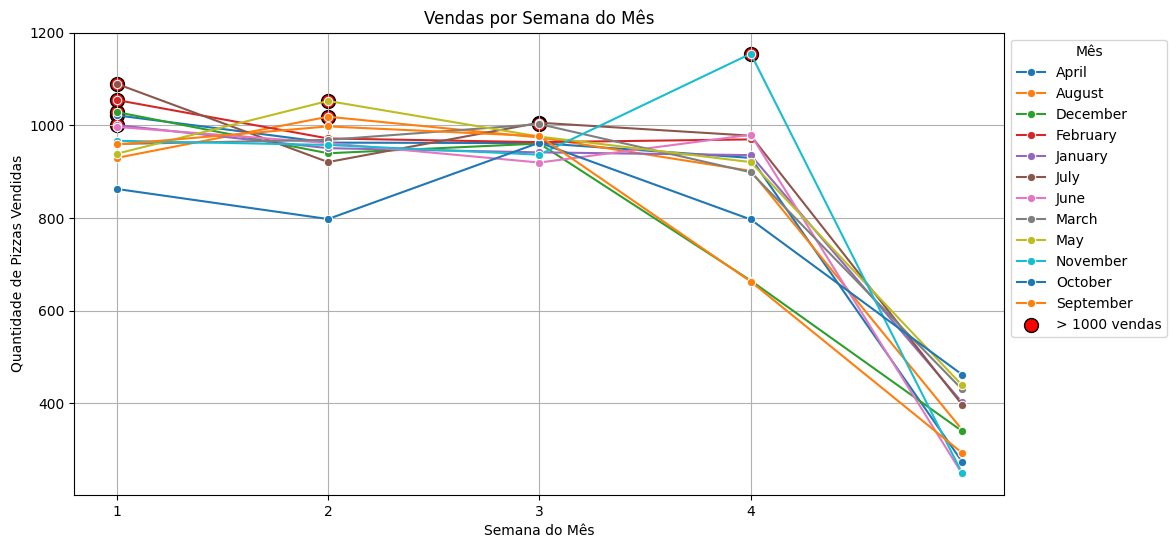

In [36]:
# Converter os números dos meses para nomes
df_pizza['month_name'] = df_pizza['month'].apply(lambda x: calendar.month_name[x])

# Agrupar as vendas por semana do mês
weekly_sales = df_pizza.groupby(['year', 'month_name', 'week_of_month'])['quantity'].sum().reset_index()

# Criar o gráfico
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=weekly_sales, x='week_of_month', y='quantity', 
                  hue='month_name', marker="o", palette="tab10")

# Destacar semanas com mais de 1000 vendas
highlight = weekly_sales[weekly_sales['quantity'] > 1000]
plt.scatter(highlight['week_of_month'], highlight['quantity'], 
            color='red', s=100, label="> 1000 vendas", edgecolor='black')

# Ajustar título e eixos
plt.title("Vendas por Semana do Mês")
plt.xlabel("Semana do Mês")
plt.ylabel("Quantidade de Pizzas Vendidas")
plt.xticks(range(1, 5))  # Considerando meses com no máximo 4 semanas completas

# Ajustar a legenda para exibir os nomes dos meses corretamente
plt.legend(title="Mês", bbox_to_anchor=(1, 1))

plt.grid()
plt.show()

Realizando a análise por semana do mês, é possível verificar que há uma predominância dos pedidos na primeira e segunda semana do mês, provavelmente relacionado ao período em que as pessoas recebem seus salários. Na última semana do mês, é possível verificar uma queda do número de pedidos.

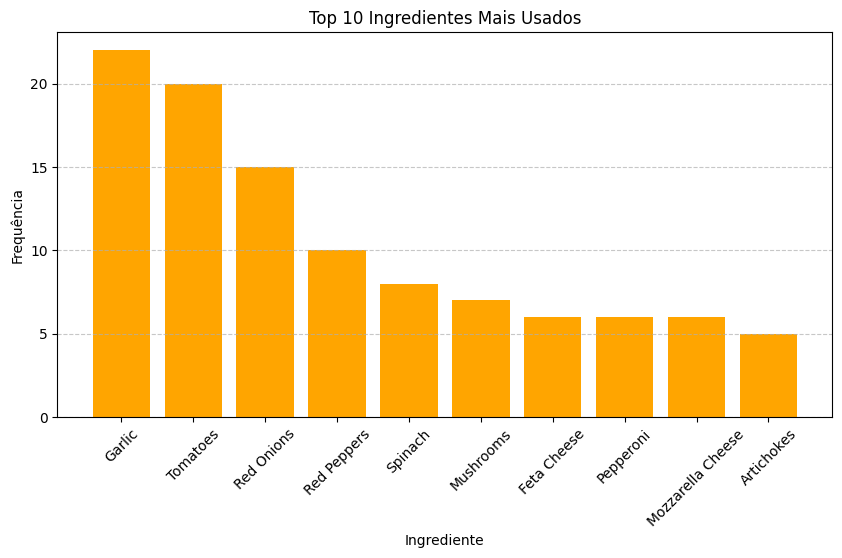

In [30]:
# Separar os ingredientes em listas
split_ingredients = df_types['pizza_ingredients'].str.split(', ')

# Achatar a lista e contar a frequência de cada ingrediente
all_ingredients = [ingredient for sublist in split_ingredients for ingredient in sublist]
ingredient_counts = pd.Series(all_ingredients).value_counts()

# Pegar os 10 ingredientes mais comuns
top_ingredients = ingredient_counts.head(10)

# Criar o gráfico de barras com Matplotlib
plt.figure(figsize=(10, 5))
plt.bar(top_ingredients.index, top_ingredients.values, color='orange')
plt.xlabel('Ingrediente')
plt.ylabel('Frequência')
plt.title('Top 10 Ingredientes Mais Usados')
plt.xticks(rotation=45)  # Rotacionar os rótulos para melhor leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionar grade para facilitar a leitura

# Mostrar o gráfico
plt.show()


## Clusterização de Pedidos

In [31]:
# Agregar as vendas por pedido
order_data = df_pizza.groupby('order_id').agg(
    total_sales=('total_price', 'sum'),
    item_count=('pizza_id', 'count'),
    average_order_value=('total_price', 'mean')
).reset_index()

# Encontrar a categoria de pizza mais comum por pedido
order_data['preferred_category'] = df_pizza.groupby('order_id')['pizza_category'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')

# Padronizar os dados
features = ['total_sales', 'item_count', 'average_order_value']
scaler = StandardScaler()
order_data_scaled = scaler.fit_transform(order_data[features])

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
order_data['cluster'] = kmeans.fit_predict(order_data_scaled)

# Transformar os centróides de volta à escala original
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original_scale, columns=features)

# Exibir os centróides dos clusters
centroids_df = centroids_df.round(2)
centroids_df

,total_sales,item_count,average_order_value
0,45.71,2.53,18.87
1,23.63,1.63,14.52
2,182.71,10.22,17.89


In [32]:
# Verificar a quantidade de pedidos em cada cluster
order_data['cluster'].value_counts(normalize=True)

cluster
0    0.488431
1    0.487119
2    0.024450
Name: proportion, dtype: float64

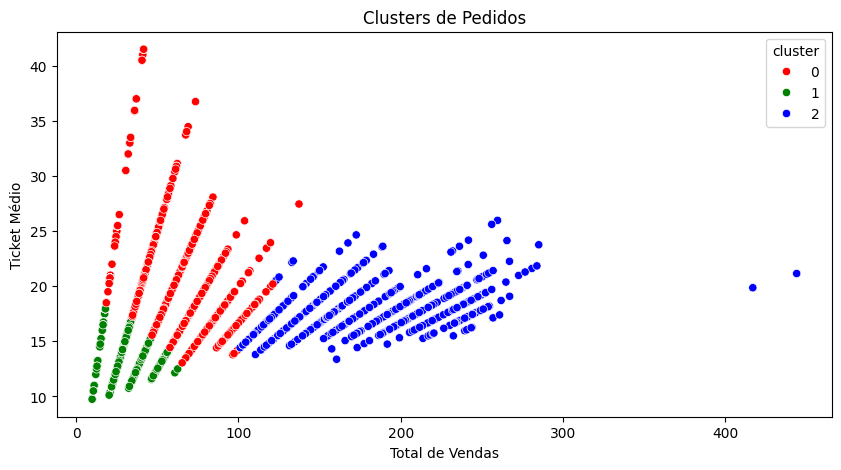

In [33]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=order_data, x='total_sales', y='average_order_value', hue='cluster', palette={0: 'red', 1: 'green', 2: 'blue'})
plt.title('Clusters de Pedidos')
plt.xlabel('Total de Vendas')
plt.ylabel('Ticket Médio')
plt.show()

Utilizando o algoritmo K-Means, foi possível determinar 3 clusters a partir dos pedidos realizados. Eles podem ser definidos da seguinte forma:
- Cluster 0:
  - Possui aproximadamente $45,71 de valor total de vendas por pedido;
  - Cerca de 2,5 itens por pedido;
  - Representa 49% dos pedidos totais da base.
- Cluster 1:
  - Possui aproximadamente $23,63 de valor total de vendas por pedido;
  - Cerca de 1,6 itens por pedido;
  - Representa 49% dos pedidos totais da base.
- Cluster 1:
  - Possui aproximadamente $182,71 de valor total de vendas por pedido;
  - Cerca de 10,2 itens por pedido;
  - Representa 2% dos pedidos totais da base.

O Cluster 0 representa o público que realiza pedidos de médio/baixo valor em relação ao total e número de produtos do pedido.<br>
O Cluster 1 representa o público que realiza pedidos de baixo valor em relação ao total e número de produtos do pedido, com foco em pedidos de tamanho menor e individuais.<br>
O Cluster 2 representa o público que realiza pedidos de alto valor e grandes quantidades de produtos, possuindo um valor médio similar ao Cluster 0, provavelmente são pedidos para eventos para um grupo de pessoas.

## Exportar base para dashboard

In [39]:
df_pizza.to_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\pizza_db.csv", index=False, sep=",")

Link do Dashboard: https://lookerstudio.google.com/reporting/50d1e569-33c6-4553-bd14-c99fc8446872

## Insights obtidos

- O número de picos durante a semana é maior na sexta-feira